In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import cv2 

import sys
import numpy as np





In [ ]:
# #img1
# lower = np.array([90,0,0])
# upper = np.array([130, 10, 10])

# #img2
# lower = np.array([90,0,0])
# upper = np.array([130, 30, 30])

#img3
lower = np.array([180,80,80])
upper = np.array([220, 110, 110])

# #img4
# lower = np.array([180,80,80])
# upper = np.array([220, 110, 110])

# #grey test
# lower = np.array([90,90,90])
# upper = np.array([125,125,125])

In [ ]:

template_path = "/home/fizzer/Desktop/gimp_plate.png"
query_path = "/home/fizzer/Desktop/license_plate3.png"

temp_img = cv2.imread(template_path)
query_img = cv2.imread(query_path)
print(query_img.shape)
#query_img = query_img[780:780+400,:800]
# sift = cv2.SIFT_create()

# kp_temp_img, desc_temp_img = sift.detectAndCompute(temp_img, None)
# kp_query_img, desc_query_img = sift.detectAndCompute(query_img, None)


# grey_query = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)
# kp_grey_img, desc_grey_img = sift.detectAndCompute(grey_query, None)

In [ ]:
frame = query_img[:, int(query_img.shape[1]/2):]
plt.imshow(frame)

In [ ]:
mask = cv2.inRange(query_img, lower,upper)
output = cv2.bitwise_and(query_img, query_img, mask=mask)

print(output.shape)
grey = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(grey, 1, 255,cv2.THRESH_BINARY)

kernel = np.ones((5,5), np.uint8)
th = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
dial = cv2.dilate(thresh, kernel, 1)
contours, hierarchy = cv2.findContours(dial, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


#cont_img = cv2.drawContours(query_img, contours, -1, (0,255,0),3)
areas = np.array([cv2.contourArea(c) for c  in contours])
sorted_areas = np.sort(areas)[::-1]
rect_areas = sorted_areas[0:2]

print(rect_areas)

# all_approx = []

# for count in contours:
#     epsilon = 0.00001 * cv2.arcLength(count, True)
    
    
#     approximations = cv2.approxPolyDP(count, epsilon, True)
    
#     if len(approximations) == 18:
#         cv2.drawContours(query_img, [approximations], -1, (0,255,0), 3)
#         all_approx.append(approximations)
#         print(len(approximations))
    
blocks = []
for c in contours:
    if cv2.contourArea(c) in rect_areas:
        blocks.append(c)

cont_img = cv2.drawContours(query_img, blocks, -1, (0,255,0),3)

        
#img_plt = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(cont_img)
# print(all_approx)

# print(len(all_approx))


In [ ]:
def avg_x(c):
    tot = 0
    for i in range(0,len(c)):
        tot = tot + c[i][0][0]
    avg = tot/ len(c)
    return avg

avg1 = avg_x(blocks[0])
avg2 = avg_x(blocks[1])

if avg1 > avg2:
    right_block = blocks[0]
    left_block = blocks[1]
else:
    right_block = blocks[1]
    left_block = blocks[0]
# print(left_block)
# print(right_block)

In [ ]:
def getPoints(c):
    points = []
    for i in range(0,len(c)):
        point = []
        point.append(c[i][0][0])
        point.append(c[i][0][1])
        points.append(point)
    return points
left_points = getPoints(left_block)
right_points = getPoints(right_block)
print(left_points)
# print(right_points)

In [ ]:
x = []
y = []

# find bottom left point of left rectangle
def find_bottom_left(points):
    x = []
    for p in points:
        x.append(sum(p))

    min_index = 0
    minval = 100000
    for i in range(0,len(x)):
        if x[i] < minval:

            minval = x[i]
            min_index = i
    return min_index

min_index = find_bottom_left(left_points)
#print(left_points[min_index])      
    
# find top right point of right rectangle
def find_top_right(points):
    y = []
    for p in points:
        y.append(sum(p))
    
    max_index = 0
    maxval = 0
    for j in range(0, len(y)):
        if y[j] > maxval:
            maxval = y[j]
            max_index = j
    return max_index

max_index = find_top_right(right_points)
#print(right_points[max_index]) 


r_min = right_points[find_bottom_left(right_points)]
r_max = right_points[find_top_right(right_points)]
l_min = left_points[find_bottom_left(left_points)]
l_max = left_points[find_top_right(left_points)]

#finding bottom left corner
#print(l_min, l_max)
l_middle = (l_min[0] + l_max[0]) / 2
#print(l_middle)

maxval= 0
index = 0
for i in range(0,len(left_points)):
    #print(left_points[i][0])
    if left_points[i][0] > l_middle:
        if left_points[i][1] < maxval:
            maxval = left_points[i][1]
            index = i
top_left_corner = left_points[index]       
#print(bottom_left_corner)

#finding top right corner
r_middle = (r_min[0] + r_max[0]) / 2

minval = 10000
kindex = 0
for j in range(0, len(right_points)):
    if right_points[j][0] < r_middle:
        if right_points[j][1] > minval:
            minval = right_points[j][1]
            jindex = j
bottom_right_corner = right_points[jindex]


#assigning bottom right, top left
top_right_corner = r_min
bottom_left_corner = l_max


perspective_pts = (top_right_corner, top_left_corner, bottom_left_corner, bottom_right_corner)
print(perspective_pts)
plt.imshow(query_img)

In [25]:
def four_point_transform(image, pts):
    """
    Applies a perspective transform to an image given four corner points.

    Args:
        image (numpy.ndarray): The image to transform.
        pts (list): The four corner points of the region of interest.

    Returns:
        numpy.ndarray: The transformed image.
    """
    # Obtain a consistent order of the points and unpack them
    rect = np.zeros((4, 2), dtype = "float32")
    s = np.sum(pts, axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
     
    # Compute the width and height of the new image
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
     
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
     
    # Construct the destination points which will be used to obtain a "birds eye view"
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype = "float32")
     
    # Compute the perspective transform matrix and apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
     
    # Return the warped image
    return warped

(252, 479, 3)


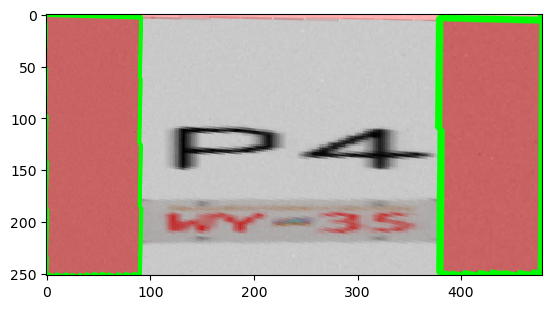

In [26]:
warp_img = four_point_transform(query_img, perspective_pts)

# cropped_img = query_img[bottom_y:top_y, left_x: right_x]
# plt.imshow(cropped_img)
# print(cropped_img.shape)

#cropped_img = query_img[bottom_y:top_y, left_x: right_x]
plt.imshow(warp_img)
print(warp_img.shape)

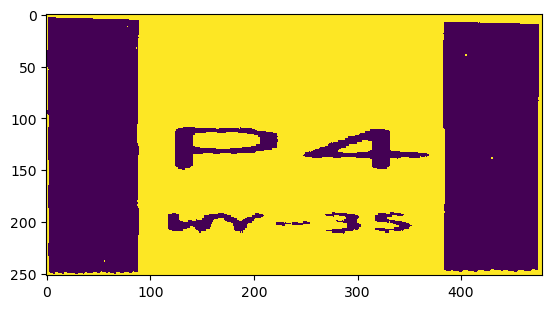

In [27]:
grey = cv2.cvtColor(warp_img, cv2.COLOR_BGR2GRAY)

thresh_value = 120

_, thresh = cv2.threshold(grey, thresh_value, 255, cv2.THRESH_BINARY)
plt.imshow(thresh)

# print(thresh[100][100])
# print(thresh[25][25])
# print(thresh[300][100])
# index goes thresh[y][x]
# purple is 0, yellow is 255

89
382


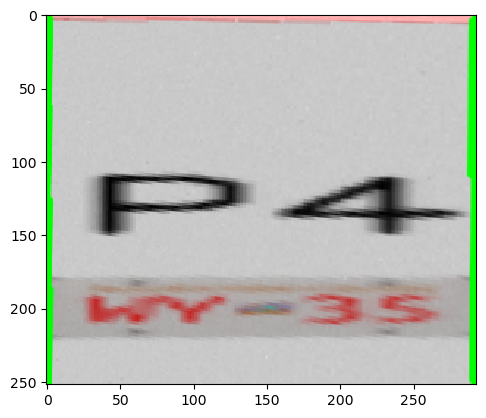

In [28]:
# purple is 0, yellow is 255
#print(thresh.shape)
white_space_index= []
for i in range(10, thresh.shape[1]-10):
    if thresh[75][i] == 255:
        white_space_index.append(i)
print(white_space_index[0])
print(white_space_index[-1])
cropwarp = warp_img[:,white_space_index[0]:white_space_index[-1]]
plt.imshow(cropwarp)

In [ ]:
# kp1_img = cv2.drawKeypoints(temp_img, kp_temp_img, temp_img)
# plt.imshow(kp1_img)


# # kp1_img = cv2.drawKeypoints(temp_img, kp_temp_img, temp_img)
# # kp2_img = cv2.drawKeypoints(query_img, kp_query_img, query_img)
# # cv2.imshow('Image', kp1_img)
# # cv2.imshow('Image2', kp2_img)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()

# index_params = dict(algorithm=0, trees=5)
# search_params = dict()
# flann = cv2.FlannBasedMatcher(index_params, search_params)


# matches = flann.knnMatch(desc_temp_img, desc_query_img, k=2)
# good_points = []
# for m, n in matches:
#     if m.distance < 0.6 * n.distance:
#         good_points.append(m)

# kp2_img = cv2.drawKeypoints(query_img, kp_grey_img, query_img)
# plt.imshow(kp2_img)

#https://stackoverflow.com/questions/66876495/opencv-homography-gives-error-the-input-arrays-should-have-at-least

# print(query_img.shape)
# if len(good_points) > 5:
#     query_pts = np.float32([kp_temp_img[m.queryIdx].pt for m in good_points]).reshape(-1, 1, 2)
#     train_pts = np.float32([kp_grey_img[m.trainIdx].pt for m in good_points]).reshape(-1, 1, 2)
#     matrix, mask = cv2.findHomography(query_pts, train_pts, cv2.RANSAC, 5.0)
#     matches_mask = mask.ravel().tolist()
    
#     h, w, d =  temp_img.shape
#     pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
#     print(pts)
#     dst = cv2.perspectiveTransform(pts, matrix)

#     homography = cv2.polylines(query_img, [np.int32(dst)], True, (255, 0, 0), 3)
            
# else:
#     homography = query_img
    

# plt.imshow(homography)

# cv2.imshow('Image2', homography)
# cv2.waitKey(0)
# cv2.destroyAllWindows()